In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import streamlit as st
from sklearn.decomposition import PCA
import joblib
from sklearn.metrics import silhouette_score, davies_bouldin_score
import json

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

In [2]:
# PRODUKSI
df_produksi22 = pd.read_csv("produksibio_22.csv")
df_produksi23 = pd.read_csv("produksibio_23.csv")
df_produksi24 = pd.read_csv("produksibio_24.csv")

In [3]:
# LUAS PANEN
df_luaspanen22 = pd.read_csv("biofarmaka_2022.csv")
df_luaspanen23 = pd.read_csv("biofarmaka_2023.csv")
df_luaspanen24 = pd.read_csv("biofarmaka_2024.csv")

In [4]:
df_produksi22["Tahun"] = 2022
df_produksi23["Tahun"] = 2023
df_produksi24["Tahun"] = 2024

df_luaspanen22["Tahun"] = 2022
df_luaspanen23["Tahun"] = 2023
df_luaspanen24["Tahun"] = 2024

In [5]:
merge22 = pd.merge(df_produksi22, df_luaspanen22, on=["Kabupaten/Kota", "Tahun"], how="inner")
merge23 = pd.merge(df_produksi23, df_luaspanen23, on=["Kabupaten/Kota", "Tahun"], how="inner")
merge24 = pd.merge(df_produksi24, df_luaspanen24, on=["Kabupaten/Kota", "Tahun"], how="inner")

In [6]:
def clean_numeric(df):
    df = df.replace("...", np.nan)
    df = df.replace(",", "", regex=True)
    for col in df.columns:
        if col not in ["Kabupaten/Kota", "Tahun"]:
            df[col] = pd.to_numeric(df[col], errors="coerce")
    df = df.fillna(0)
    return df

In [7]:
# fungsi hapus baris tidak valid
def clean_invalid_rows(df):
    invalid_names = [0, "Catatan", "Angka sementara", "Angka Sementara", "Angka tetap", "Kota Sukabumi", "Kota Cirebon"]
    df = df[~df["Kabupaten/Kota"].isin(invalid_names)]
    return df

In [8]:
# apply numeric clean + hapus baris invalid
merge22 = clean_invalid_rows(clean_numeric(merge22))
merge23 = clean_invalid_rows(clean_numeric(merge23))
merge24 = clean_invalid_rows(clean_numeric(merge24))

C:\Users\user\AppData\Local\Temp\ipykernel_5104\3059231525.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace("...", np.nan)


In [9]:
def create_final_dataset(df):
    kolom_produksi = [c for c in df.columns if "Produksi" in c]
    kolom_luas = [c for c in df.columns if "Luas Panen" in c]
    
    df["Produksi_Total"] = df[kolom_produksi].sum(axis=1)
    df["LuasPanen_Total"] = df[kolom_luas].sum(axis=1)
    
    final = df[["Tahun", "Kabupaten/Kota", "Produksi_Total", "LuasPanen_Total"]]
    return final

In [10]:
dataset22 = create_final_dataset(merge22)
dataset23 = create_final_dataset(merge23)
dataset24 = create_final_dataset(merge24)

In [11]:
dataset22.to_csv("dataset_2022.csv", index=False)
dataset23.to_csv("dataset_2023.csv", index=False)
dataset24.to_csv("dataset_2024.csv", index=False)

In [12]:
def clean_numeric(df):
    # --- TAMBAHAN: Bersihkan Nama Kolom ---
    terms_to_remove = ['Angka Sementara', 'Angka Tetap', 'Catatan', 'Angka sementara', 'Angka tetap']
    new_columns = {}
    for col in df.columns:
        clean_name = col
        for term in terms_to_remove:
            clean_name = clean_name.replace(term, '')
        # Merapikan spasi ganda hasil penghapusan kata
        new_columns[col] = " ".join(clean_name.split()).strip()
    df = df.rename(columns=new_columns)
    # -------------------------------------

    df = df.replace("...", np.nan)
    df = df.replace(",", "", regex=True)
    for col in df.columns:
        if col not in ["Kabupaten/Kota", "Tahun"]:
            df[col] = pd.to_numeric(df[col], errors="coerce")
    df = df.fillna(0)
    return df

In [13]:
def clean_invalid_rows(df):
    # Hapus baris yang mengandung kata kunci di kolom Kabupaten/Kota
    invalid_keywords = ["Catatan", "Angka sementara", "Angka tetap"]
    
    # Memastikan kolom Kabupaten/Kota berupa string sebelum difilter
    df = df[~df["Kabupaten/Kota"].astype(str).str.contains('|'.join(invalid_keywords), na=False, case=False)]
    
    # Tetap hapus wilayah lain yang sebelumnya Anda tentukan
    other_invalid = ["Kota Sukabumi", "Kota Cirebon", 0, "0"]
    df = df[~df["Kabupaten/Kota"].isin(other_invalid)]
    return df

In [14]:
# Apply numeric clean + hapus baris invalid (Sekarang sudah termasuk hapus label status di kolom)
merge22 = clean_invalid_rows(clean_numeric(merge22))
merge23 = clean_invalid_rows(clean_numeric(merge23))
merge24 = clean_invalid_rows(clean_numeric(merge24))

In [15]:
dataset22.head(50)

,Tahun,Kabupaten/Kota,Produksi_Total,LuasPanen_Total
0,2022,Bogor,17383212.0,4527741.0
1,2022,Sukabumi,8322208.0,6015130.0
2,2022,Cianjur,50634480.0,8318647.0
3,2022,Bandung,1544136.0,770980.0
4,2022,Garut,46143356.0,27641744.0
5,2022,Tasikmalaya,20811393.0,9640809.0
6,2022,Ciamis,6443561.0,4924512.0
7,2022,Kuningan,4158491.0,1620963.0
8,2022,Cirebon,173827.0,58579.0
9,2022,Majalengka,3818336.0,1053619.0


In [16]:
dataset23.head(50)

,Tahun,Kabupaten/Kota,Produksi_Total,LuasPanen_Total
0,2023,Bogor,15558240.0,2946456.0
1,2023,Sukabumi,14202065.0,5300417.0
2,2023,Cianjur,46489658.0,8600047.0
3,2023,Bandung,3297410.0,1058169.0
4,2023,Garut,40001164.0,19663539.0
5,2023,Tasikmalaya,18544125.0,9731169.0
6,2023,Ciamis,3396224.0,4749599.0
7,2023,Kuningan,2491794.0,1432793.0
8,2023,Cirebon,220915.0,63093.0
9,2023,Majalengka,4228187.0,1320538.0


In [17]:
dataset24.head(50)

,Tahun,Kabupaten/Kota,Produksi_Total,LuasPanen_Total
0,2024,Bogor,34291058.0,3781850.0
1,2024,Sukabumi,9300351.0,4016660.0
2,2024,Cianjur,39189349.0,6475338.0
3,2024,Bandung,2387941.0,572228.0
4,2024,Garut,75424840.0,33806848.0
5,2024,Tasikmalaya,11663027.0,5345972.0
6,2024,Ciamis,2361684.0,3323829.0
7,2024,Kuningan,6351477.0,1909046.0
8,2024,Cirebon,482940.0,85035.0
9,2024,Majalengka,6161987.0,2759457.0


In [18]:
def elbow_plot(data, tahun):
    distortions = []
    K = range(1, 10)

    for k in K:
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(data)
        distortions.append(kmeans.inertia_)

    plt.figure(figsize=(6,4))
    plt.plot(K, distortions, marker='o')
    plt.title(f'Elbow Method Tahun {tahun}')
    plt.xlabel('Jumlah Cluster')
    plt.ylabel('Inertia')
    plt.show()

In [19]:
def clustering_tahunan(df, tahun, n_cluster=3):

    print(f"\n===== CLUSTERING TAHUN {tahun} =====")

    # ambil fitur numerik
    X = df[["Produksi_Total", "LuasPanen_Total"]]

    # normalisasi
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # tampilkan elbow
    elbow_plot(X_scaled, tahun)

    # jalankan k-means
    kmeans = KMeans(n_clusters=n_cluster, random_state=42)
    labels = kmeans.fit_predict(X_scaled)

    df[f"Cluster_{tahun}"] = labels

    # tampilkan hasil
    print(df[["Kabupaten/Kota", f"Cluster_{tahun}"]])

    # simpan csv
    df.to_csv(f"cluster_{tahun}.csv", index=False)

    # scatter plot cluster
    plt.figure(figsize=(6,4))
    plt.scatter(X_scaled[:,0], X_scaled[:,1], c=labels)
    plt.title(f"Visualisasi Cluster Tahun {tahun}")
    plt.xlabel("Produksi (scaled)")
    plt.ylabel("Luas Panen (scaled)")
    plt.show()

    return df

In [20]:
df_final = dataset24.copy() # Menggunakan data tahun 2024
fitur = ["Produksi_Total", "LuasPanen_Total"]
X = df_final[fitur]

In [21]:
scaler = StandardScaler()
scaled_features = scaler.fit_transform(X)

In [22]:
optimal_k = 3  # Kita tentukan 3 cluster
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
df_final['Cluster'] = kmeans.fit_predict(scaled_features)

In [23]:
skor_silhouette = silhouette_score(scaled_features, df_final['Cluster'])
skor_db = davies_bouldin_score(scaled_features, df_final['Cluster'])

print(f"Skor Silhouette: {skor_silhouette:.3f}")
print(f"Skor Davies-Bouldin: {skor_db:.3f}")

Skor Silhouette: 0.825
Skor Davies-Bouldin: 0.060


In [24]:
df22 = pd.read_csv("dataset_2022.csv")
df23 = pd.read_csv("dataset_2023.csv")
df24 = pd.read_csv("dataset_2024.csv")


===== CLUSTERING TAHUN 2022 =====


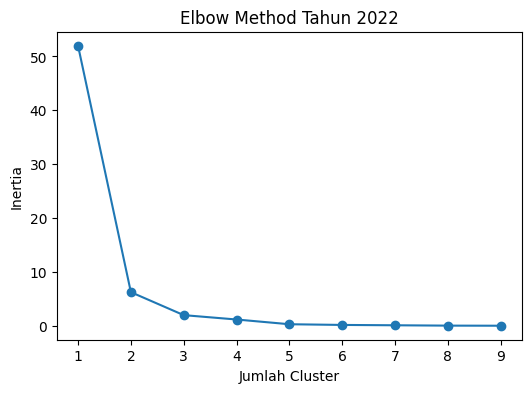

      Kabupaten/Kota  Cluster_2022
0              Bogor             0
1           Sukabumi             0
2            Cianjur             2
3            Bandung             0
4              Garut             2
5        Tasikmalaya             0
6             Ciamis             0
7           Kuningan             0
8            Cirebon             0
9         Majalengka             0
10          Sumedang             0
11         Indramayu             0
12            Subang             0
13        Purwakarta             0
14          Karawang             0
15            Bekasi             0
16     Bandung Barat             0
17       Pangandaran             0
18        Kota Bogor             0
19      Kota Bandung             0
20       Kota Bekasi             0
21        Kota Depok             0
22       Kota Cimahi             0
23  Kota Tasikmalaya             0
24       Kota Banjar             0
25        Jawa Barat             1


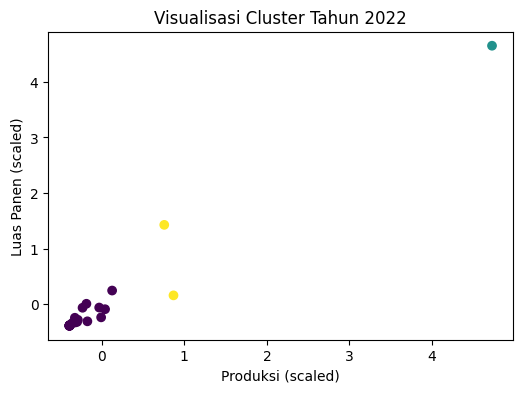


===== CLUSTERING TAHUN 2023 =====


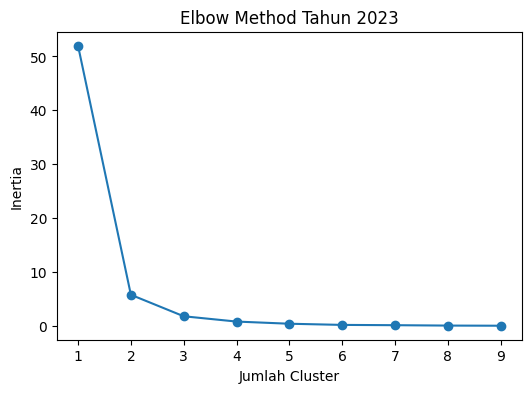

      Kabupaten/Kota  Cluster_2023
0              Bogor             0
1           Sukabumi             0
2            Cianjur             2
3            Bandung             0
4              Garut             2
5        Tasikmalaya             0
6             Ciamis             0
7           Kuningan             0
8            Cirebon             0
9         Majalengka             0
10          Sumedang             0
11         Indramayu             0
12            Subang             0
13        Purwakarta             0
14          Karawang             0
15            Bekasi             0
16     Bandung Barat             0
17       Pangandaran             0
18        Kota Bogor             0
19      Kota Bandung             0
20       Kota Bekasi             0
21        Kota Depok             0
22       Kota Cimahi             0
23  Kota Tasikmalaya             0
24       Kota Banjar             0
25        Jawa Barat             1


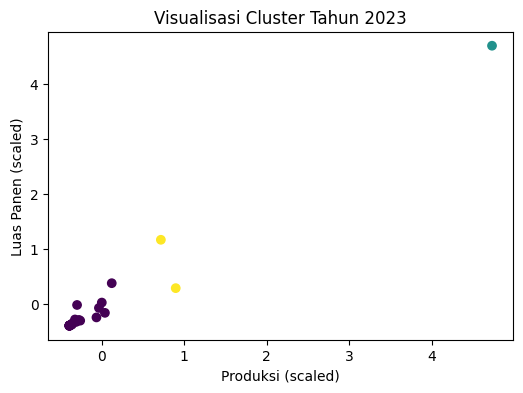


===== CLUSTERING TAHUN 2024 =====


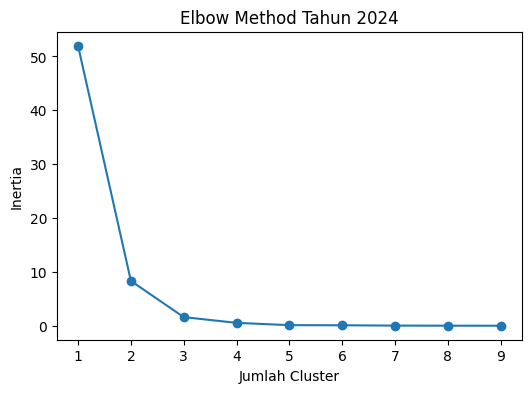

      Kabupaten/Kota  Cluster_2024
0              Bogor             0
1           Sukabumi             0
2            Cianjur             0
3            Bandung             0
4              Garut             2
5        Tasikmalaya             0
6             Ciamis             0
7           Kuningan             0
8            Cirebon             0
9         Majalengka             0
10          Sumedang             0
11         Indramayu             0
12            Subang             0
13        Purwakarta             0
14          Karawang             0
15            Bekasi             0
16     Bandung Barat             0
17       Pangandaran             0
18        Kota Bogor             0
19      Kota Bandung             0
20       Kota Bekasi             0
21        Kota Depok             0
22       Kota Cimahi             0
23  Kota Tasikmalaya             0
24       Kota Banjar             0
25        Jawa Barat             1


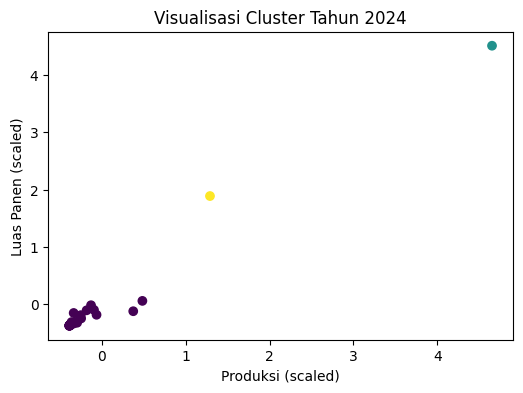

In [25]:
cluster_2022 = clustering_tahunan(df22, 2022)
cluster_2023 = clustering_tahunan(df23, 2023)
cluster_2024 = clustering_tahunan(df24, 2024)

In [26]:
bundle = {
    "model": kmeans,
    "scaler": scaler
}

joblib.dump(bundle, "kmeans.pkl")

['kmeans.pkl']

In [27]:
joblib.dump(kmeans,"model.pkl")

['model.pkl']